In [1]:
%load_ext watermark


In [2]:
import os

import downstream
import imageio
from IPython.display import display
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from teeplot import teeplot as tp
from tqdm import tqdm

from pylib.munge._addend_groups import addend_groups
from pylib.munge._union_upsample import union_upsample
from pylib.munge._squeeze import squeeze_int


In [3]:
%watermark -diwmuv -iv


Last updated: 2025-08-03T01:14:07.756294+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1031-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

pandas    : 2.2.3
teeplot   : 1.2.0
polars    : 1.9.0
downstream: 1.6.2
imageio   : 2.36.1
seaborn   : 0.13.2
numpy     : 2.1.2

Watermark: 2.4.3



In [4]:
teeplot_subdir = "wse-denovo-spatial2d-explicitsite-timeseries"
teeplot_subdir


'wse-denovo-spatial2d-explicitsite-timeseries'

## Prep Data


In [5]:
dfxs = pl.from_pandas(
    pd.read_parquet("https://osf.io/fm8dt/download"),
).with_row_index(
    "dstream_data_id",
)
display(dfxs.describe()), display(dfxs.head()), display(dfxs.tail());


statistic,dstream_data_id,data_hex,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,nWav,nTrait,nCycle,nColSubgrid,nRowSubgrid,nonBlock,tilePopSize,tournSize,msec,tsc,replicate,netbencount_hexoffset,netbencount_hexwidth,mutator_hexoffset,mutator_hexwidth,delcount_hexoffset,delcount_hexwidth,counter_hexoffset,counter_hexwidth,snapshot_netbencount_hexoffset,snapshot_netbencount_hexwidth,snapshot_counter_hexoffset,snapshot_counter_hexwidth,snapshot_counter_dilation,_compconf_dummy,CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS,CEREBRASLIB_TRAITLOGGER_NUM_BITS,CEREBRASLIB_TRAITLOGGER_DSTREAM_ALGO_NAME,CEREBRASLIB_TRAITLOGGER_DILATION,ASYNC_GA_GENOME_FLAVOR,dstream_algo,dstream_storage_bitoffset,dstream_storage_bitwidth,dstream_S,dstream_T_bitoffset,dstream_T_bitwidth,trait_value
str,f64,str,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,str,str,f64,f64,f64,f64,f64,f64
"""count""",2.2365e7,"""22365000""",2.2365e7,2.2365e7,2.2365e7,"""22365000""",2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,"""22365000""",2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,"""22365000""",2.2365e7,"""22365000""","""22365000""",2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7,2.2365e7
"""null_count""",0.0,"""0""",0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1.1182e7,null,372749.5,496.5,374.5,null,15.5,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,0.0,256.0,1.1,0.0,0.0,null,0.0,4.0,4.0,2.0,6.0,2.0,8.0,8.0,16.0,4.0,20.0,4.0,8.0,42.0,14.0,256.0,null,8.0,null,null,0.0,256.0,256.0,256.0,32.0,0.0
"""std""",6.4562e6,null,215207.317651,286.942945,216.506163,null,8.655442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.414214,0.0,null,0.0,null,null,0.0,0.0,0.0,0.0,0.0,0.0
"""min""",0.0,"""000000000000000000000000000000…",0.0,0.0,0.0,null,1.0,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,0.0,256.0,1.1,0.0,0.0,null,0.0,4.0,4.0,2.0,6.0,2.0,8.0,8.0,16.0,4.0,20.0,4.0,8.0,42.0,12.0,256.0,null,8.0,null,null,0.0,256.0,256.0,256.0,32.0,0.0
"""25%""",5.59125e6,null,186375.0,248.0,187.0,null,8.0,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,null,256.0,1.1,0.0,0.0,null,0.0,4.0,4.0,2.0,6.0,2.0,8.0,8.0,16.0,4.0,20.0,4.0,8.0,42.0,13.0,256.0,null,8.0,null,null,0.0,256.0,256.0,256.0,32.0,0.0
"""50%""",1.11825e7,null,372750.0,497.0,375.0,null,16.0,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,null,256.0,1.1,0.0,0.0,null,0.0,4.0,4.0,2.0,6.0,2.0,8.0,8.0,16.0,4.0,20.0,4.0,8.0,42.0,14.0,256.0,null,8.0,null,null,0.0,256.0,256.0,256.0,32.0,0.0
"""75%""",1.6773749e7,null,559124.0,745.0,562.0,null,23.0,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,null,256.0,1.1,0.0,0.0,null,0.0,4.0,4.0,2.0,6.0,2.0,8.0,8.0,16.0,4.0,20.0,4.0,8.0,42.0,15.0,256.0,null,8.0,null,null,0.0,256.0,256.0,256.0,32.0,0.0
"""max""",2.2364999e7,"""ffffffffffffffffffffffffffffff…",745499.0,993.0,749.0,null,30.0,750.0,994.0,3.0,2.0,300000.0,0.0,0.0,0.0,256.0,1.1,0.0,0.0,null,0.0,4.0,4.0,2.0,6.0,2.0,8.0,8.0,16.0,4.0,20.0,4.0,8.0,42.0,16.0,256.0,null,8.0,null,null,0.0,256.0,256.0,256.0,32.0,0.0


dstream_data_id,data_hex,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,nWav,nTrait,nCycle,nColSubgrid,nRowSubgrid,nonBlock,tilePopSize,tournSize,msec,tsc,replicate,netbencount_hexoffset,netbencount_hexwidth,mutator_hexoffset,mutator_hexwidth,delcount_hexoffset,delcount_hexwidth,counter_hexoffset,counter_hexwidth,snapshot_netbencount_hexoffset,snapshot_netbencount_hexwidth,snapshot_counter_hexoffset,snapshot_counter_hexwidth,snapshot_counter_dilation,_compconf_dummy,CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS,CEREBRASLIB_TRAITLOGGER_NUM_BITS,CEREBRASLIB_TRAITLOGGER_DSTREAM_ALGO_NAME,CEREBRASLIB_TRAITLOGGER_DILATION,ASYNC_GA_GENOME_FLAVOR,dstream_algo,dstream_storage_bitoffset,dstream_storage_bitwidth,dstream_S,dstream_T_bitoffset,dstream_T_bitwidth,trait_value
u32,str,u32,u16,u16,cat,u32,u16,u16,u8,u8,u32,u16,u16,bool,u16,f32,f32,u64,cat,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u32,i16,u32,cat,u32,cat,cat,u16,u16,u16,u16,u16,u16
0,"""0687183666d2db6dfaffffffffffff…",0,0,0,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""219e5d9d-07ee-48c0-871a-93fa7c…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…","""dstream.hybrid_0_steady_1_stre…",0,256,256,256,32,0
1,"""0687183666d2db6dfaffffffffffff…",1,0,1,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""219e5d9d-07ee-48c0-871a-93fa7c…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…","""dstream.hybrid_0_steady_1_stre…",0,256,256,256,32,0
2,"""0687183666d2db6dfaffffffffffff…",2,0,2,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""219e5d9d-07ee-48c0-871a-93fa7c…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…","""dstream.hybrid_0_steady_1_stre…",0,256,256,256,32,0
3,"""0687183666d2db6dfaffffffffffff…",3,0,3,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""219e5d9d-07ee-48c0-871a-93fa7c…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…","""dstream.hybrid_0_steady_1_stre…",0,256,256,256,32,0
4,"""0687183666d2db6dfaffffffffffff…",4,0,4,"""genome_hypermutator_cappedxl_d…",1,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""219e5d9d-07ee-48c0-871a-93fa7c…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,12,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…","""dstream.hybrid_0_steady_1_stre…",0,256,256,256,32,0


dstream_data_id,data_hex,tile,row,col,genomeFlavor,globalSeed,nCol,nRow,nWav,nTrait,nCycle,nColSubgrid,nRowSubgrid,nonBlock,tilePopSize,tournSize,msec,tsc,replicate,netbencount_hexoffset,netbencount_hexwidth,mutator_hexoffset,mutator_hexwidth,delcount_hexoffset,delcount_hexwidth,counter_hexoffset,counter_hexwidth,snapshot_netbencount_hexoffset,snapshot_netbencount_hexwidth,snapshot_counter_hexoffset,snapshot_counter_hexwidth,snapshot_counter_dilation,_compconf_dummy,CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS,CEREBRASLIB_TRAITLOGGER_NUM_BITS,CEREBRASLIB_TRAITLOGGER_DSTREAM_ALGO_NAME,CEREBRASLIB_TRAITLOGGER_DILATION,ASYNC_GA_GENOME_FLAVOR,dstream_algo,dstream_storage_bitoffset,dstream_storage_bitwidth,dstream_S,dstream_T_bitoffset,dstream_T_bitwidth,trait_value
u32,str,u32,u16,u16,cat,u32,u16,u16,u8,u8,u32,u16,u16,bool,u16,f32,f32,u64,cat,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u32,i16,u32,cat,u32,cat,cat,u16,u16,u16,u16,u16,u16
22364995,"""fefffffffefffff6ffffffeaffffff…",745495,993,745,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a114b4-4a02-45e2-bbd9-7c3c22…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,16,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…","""dstream.hybrid_0_steady_1_stre…",0,256,256,256,32,0
22364996,"""fefffffffffffffefffffffaffffff…",745496,993,746,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a114b4-4a02-45e2-bbd9-7c3c22…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,16,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…","""dstream.hybrid_0_steady_1_stre…",0,256,256,256,32,0
22364997,"""fefffffffffffffefffffffaffffff…",745497,993,747,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a114b4-4a02-45e2-bbd9-7c3c22…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,16,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…","""dstream.hybrid_0_steady_1_stre…",0,256,256,256,32,0
22364998,"""feffffffffffffffffffffffffffff…",745498,993,748,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a114b4-4a02-45e2-bbd9-7c3c22…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,16,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…","""dstream.hybrid_0_steady_1_stre…",0,256,256,256,32,0
22364999,"""feffffffffffffffffffffffffffff…",745499,993,749,"""genome_hypermutator_cappedxl_d…",30,750,994,3,2,300000,0,0,false,256,1.1,0.0,0,"""93a114b4-4a02-45e2-bbd9-7c3c22…",0,4,4,2,6,2,8,8,16,4,20,4,8,42,16,256,"""hybrid_0_steady_1_stretched_2_…",8,"""genome_hypermutator_cappedxl_d…","""dstream.hybrid_0_steady_1_stre…",0,256,256,256,32,0


In [6]:
def unpack_logger_timeseries_data(df: pl.DataFrame) -> pl.DataFrame:

    # sample every 64th tile
    df = df.filter((pl.col("col") % 8 == 0) & (pl.col("row") % 8 == 0))

    # unpack dstream data items from logger hex strings
    dfu = downstream.dataframe.unpack_data_packed(df)
    df = downstream.dataframe.explode_lookup_unpacked(
        dfu.with_columns(
            # fast forward loggers to at least dstream_S entries
            # (i.e., buffer filled)
            # these will be semantically-correct zero values
            dstream_T=pl.max_horizontal(
                pl.col("dstream_T"), pl.col("dstream_S")
            ),
        ),
        value_type="uint8",
    )

    # join metadata onto unpacked data
    df = df.join(
        dfu.select(
            "dstream_data_id",
            "CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS",
            "CEREBRASLIB_TRAITLOGGER_DILATION",
            "col",
            "replicate",
            "row",
            "tile",
        ),
        on="dstream_data_id",
    )

    # apply dilation to dstream_T and dstream_Tbar
    df = df.with_columns(
        dstream_T=pl.col("dstream_T")
        * pl.col("CEREBRASLIB_TRAITLOGGER_DILATION"),
        dstream_Tbar=pl.col("dstream_Tbar")
        * pl.col("CEREBRASLIB_TRAITLOGGER_DILATION"),
    )

    # addend time time series groups with final zero value entry
    df = addend_groups(
        df,
        group_by=["replicate", "tile"],
        aggs=(
            pl.col("CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS")
            .unique()
            .pipe(squeeze_int),
            pl.col("col").unique().pipe(squeeze_int),
            (pl.col("dstream_Tbar") + 1).max().alias("dstream_Tbar"),
            pl.lit(0).alias("dstream_value"),
            pl.col("row").unique().pipe(squeeze_int),
        ),
        inner_only=True,
    )

    # upsample to fill in dstream_Tbar dropped by some loggers
    # prevents ampling biases from longer-running vs shorter-running loggers
    df = union_upsample(
        df,
        upsample="dstream_Tbar",
        group_by="tile",
        fill_null_ops=[
            (pl.all(), {"strategy": "forward"}),
            (pl.col("dstream_Tbar", "dstream_value"), {"strategy": "zero"}),
            (pl.all(), {"strategy": "backward"}),
        ],
    )
    assert len(df["dstream_Tbar"].value_counts()["count"].unique()) == 1

    return df


In [7]:
res = []
for _, df in tqdm(dfxs.group_by("replicate")):
    df = unpack_logger_timeseries_data(df)
    res.append(df)

df = pl.concat(res)


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/downstream/dataframe/_impl/_check_downstream_version.py:29: UserWarning: Dataframe downstream_version column not provided
  warnings.warn(
1it [00:01,  1.58s/it]/usr/local/lib/python3.10/dist-packages/downstream/dataframe/_impl/_check_downstream_version.py:29: UserWarning: Dataframe downstream_version column not provided
  warnings.warn(
2it [00:02,  1.45s/it]/usr/local/lib/python3.10/dist-packages/downstream/dataframe/_impl/_check_downstream_version.py:29: UserWarning: Dataframe downstream_version column not provided
  warnings.warn(
3it [00:04,  1.49s/it]/usr/local/lib/python3.10/dist-packages/downstream/dataframe/_impl/_check_downstream_version.py:29: UserWarning: Dataframe downstream_version column not provided
  warnings.warn(
4it [00:06,  1.60s/it]/usr/local/lib/python3.10/dist-packages/downstream/dataframe/_impl/_check_downstream_version.py:29: UserWarning: Dataframe downstream_version column not provided
  warnings.warn(

## Plot Data


In [8]:
# take the mean of dstream_value at each dstream_Tbar across tiles
df_mean = df.group_by("replicate", "dstream_Tbar").agg(
    pl.col("dstream_value").mean(),
    pl.col("CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS")
    .unique()
    .pipe(squeeze_int),
)


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


teeplots/wse-denovo-spatial2d-explicitsite-timeseries/col=replicate-number+hue=replicate+kind=line+row=cerebraslib-hypermut-num-avail-ben-muts+viz=relplot+x=dstream-tbar+y=dstream-value+ext=.pdf
teeplots/wse-denovo-spatial2d-explicitsite-timeseries/col=replicate-number+hue=replicate+kind=line+row=cerebraslib-hypermut-num-avail-ben-muts+viz=relplot+x=dstream-tbar+y=dstream-value+ext=.png


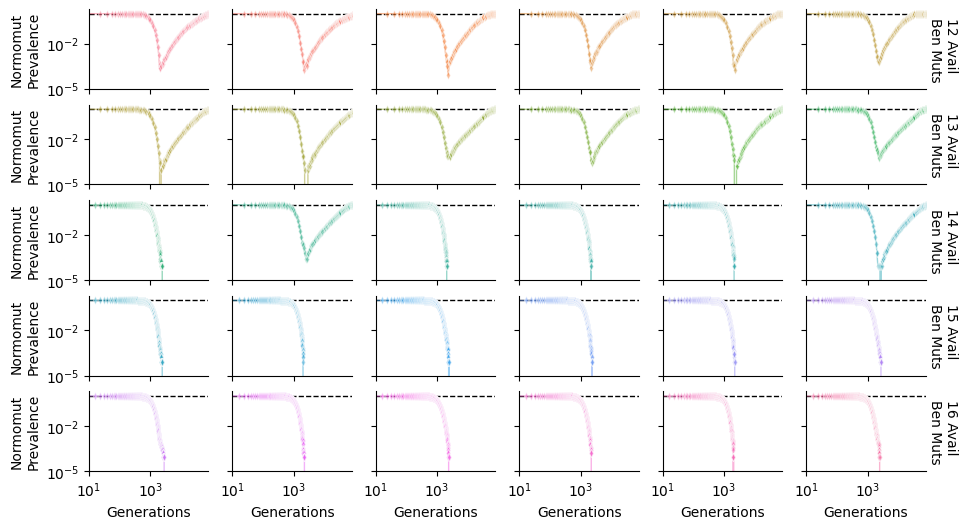

In [9]:
with tp.teed(
    sns.relplot,
    data=df_mean.with_columns(
        pl.col("replicate")
        .rank(method="dense")
        .over("CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS")
        .cast(pl.Int32)
        .alias("replicate number")
    ),
    x="dstream_Tbar",
    y="dstream_value",
    hue="replicate",
    col="replicate number",
    row="CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS",
    alpha=0.5,
    aspect=1.5,
    errorbar=None,
    height=1.2,
    linewidth=1,
    legend=False,
    kind="line",
    marker="d",
    markersize=4,
    markers=True,
    facet_kws=dict(margin_titles=True),
    teeplot_subdir=teeplot_subdir,
    teeplot_outexclude=["marker"],
) as g:
    g.set(xlim=(10, 80000))
    g.set(ylim=(0.00001, 2))
    g.set_titles(
        col_template="",
        row_template="{row_name} Avail\nBen Muts",
    )
    g.set_axis_labels(x_var="Generations", y_var="Normomut\nPrevalence")
    for ax in g.axes.flat:
        ax.axhline(1, ls="--", color="black", linewidth=1, zorder=-10)
        ax.set_yscale("log")
        ax.set_xscale("log")


## Animate Data


In [10]:
os.makedirs(teeplot_subdir, exist_ok=True)

for (replicate, nmut), dfr in tqdm(
    df.group_by("replicate", "CEREBRASLIB_HYPERMUT_NUM_AVAIL_BEN_MUTS"),
):
    frames = []
    for (dstream_Tbar,), dff in dfr.sort("dstream_Tbar").group_by(
        "dstream_Tbar", maintain_order=True
    ):

        dff = dff.with_columns(
            col_rank=pl.col("col").rank(method="dense").cast(pl.Int32) - 1,
            row_rank=pl.col("row").rank(method="dense").cast(pl.Int32) - 1,
        )

        num_rows = dff["row_rank"].max() + 1
        num_cols = dff["col_rank"].max() + 1

        frame = np.empty((num_rows, num_cols), dtype=np.uint8)
        frame[dff["row_rank"], dff["col_rank"]] = dff["dstream_value"] * 255
        frame = np.kron(frame, np.ones((4, 4), dtype=frame.dtype))
        frames.append(frame)

        outdir = f"{teeplot_subdir}/a=traitframes+nmut={nmut}+rep={replicate}"
        os.makedirs(outdir, exist_ok=True)
        outpath = f"{outdir}/dstream_Tbar={dstream_Tbar:06}+ext=.png"
        imageio.imwrite(outpath, frame.T)

    print(len(frames))
    outpath = f"{teeplot_subdir}/a=traits+nmut={nmut}+rep={replicate}+ext=.gif"
    imageio.mimsave(outpath, frames, duration=0.2)


0it [00:00, ?it/s]

257


1it [00:19, 19.27s/it]

281


2it [00:23, 10.16s/it]

286


3it [00:26,  7.25s/it]

286


4it [00:30,  5.91s/it]

257


5it [00:33,  4.88s/it]

261


6it [00:37,  4.39s/it]

285


7it [00:40,  4.18s/it]

269


8it [00:44,  3.97s/it]

257


9it [00:47,  3.71s/it]

269


10it [00:51,  3.68s/it]

257


11it [00:54,  3.51s/it]

257


12it [00:57,  3.32s/it]

257


13it [01:00,  3.36s/it]

307


14it [01:04,  3.52s/it]

257


15it [01:07,  3.32s/it]

257


16it [01:10,  3.36s/it]

257


17it [01:13,  3.22s/it]

257


18it [01:16,  3.12s/it]

257


19it [01:19,  3.12s/it]

290


20it [01:23,  3.35s/it]

257


21it [01:26,  3.28s/it]

257


22it [01:29,  3.17s/it]

272


23it [01:33,  3.32s/it]

257


24it [01:36,  3.24s/it]

306


25it [01:40,  3.47s/it]

269


26it [01:44,  3.51s/it]

284


27it [01:47,  3.57s/it]

257


28it [01:50,  3.36s/it]

266


29it [01:54,  3.41s/it]

257


30it [01:57,  3.90s/it]
